In [54]:
# This Dataset is on a Dataset for CreditCard Churn
# Need to Analyse the Data and then Predict

Import Libraries  and Import the Data

In [55]:
!pip install catboost

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin



Read the Data into the DataFrame

In [57]:
df = pd.read_csv('BankChurners.csv')

# Basic EDA

In [58]:
# Check the final info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

The dataset contains 10,127 entries and there are no missing values in any of the columns.

The data types of the columns are as follows:

10 columns are of integer type.
5 columns are of float type.
6 columns are of object type (usually strings), which indicates they are likely categorical variables.

#Compute the Descriptive statistics for numerical columns

In [59]:
# Compute descriptive statistics for numerical columns
numerical_descriptive_stats = df.describe()

# Compute frequency distribution for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_frequency_distribution = df[categorical_columns].apply(lambda x: x.value_counts()).T.stack()

numerical_descriptive_stats, categorical_frequency_distribution


(          CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
 count  1.012700e+04  10127.000000     10127.000000    10127.000000   
 mean   7.391776e+08     46.325960         2.346203       35.928409   
 std    3.690378e+07      8.016814         1.298908        7.986416   
 min    7.080821e+08     26.000000         0.000000       13.000000   
 25%    7.130368e+08     41.000000         1.000000       31.000000   
 50%    7.179264e+08     46.000000         2.000000       36.000000   
 75%    7.731435e+08     52.000000         3.000000       40.000000   
 max    8.283431e+08     73.000000         5.000000       56.000000   
 
        Total_Relationship_Count  Months_Inactive_12_mon  \
 count              10127.000000            10127.000000   
 mean                   3.812580                2.341167   
 std                    1.554408                1.010622   
 min                    1.000000                0.000000   
 25%                    3.000000                2.000000   

The average age of customers is around 46 years, with a minimum of 26 and a maximum of 73.

The number of dependents varies from 0 to 5, with an average of about 2.3 dependents per customer.

The length of time an account has been open varies from 13 to 56 months, with an average of 35.9 months.

The total number of products held by a customer varies from 1 to 6, with an average of about 3.8 products per customer.

The average credit limit is around 8631, but it varies widely, with the minimum limit being $1438 and the maximum being 34516.

In the Attrition_Flag column, there are significantly more 'Existing Customer' entries (8500) than 'Attrited Customer' entries (1627). This implies that the dataset is imbalanced.

For Gender, there are slightly more female customers (5358) than male customers (4769).

In the Education_Level column, the 'Graduate' level is the most frequent, followed by 'High School' and 'Uneducated'. There are also 1519 'Unknown' entries.

In Marital_Status, most customers are 'Married', followed by 'Single'. There are also 749 'Unknown' entries.

In Income_Category, the most common category is 'Less than $40K', followed by '$40K - $60K'.

For the Card_Category, most customers have a 'Blue' card. There are very few customers with 'Gold' or 'Platinum' cards.




#Check for duplicate rows in the dataset.

In [60]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
duplicate_rows


0

 # Visualizations to understand the distribution of the data

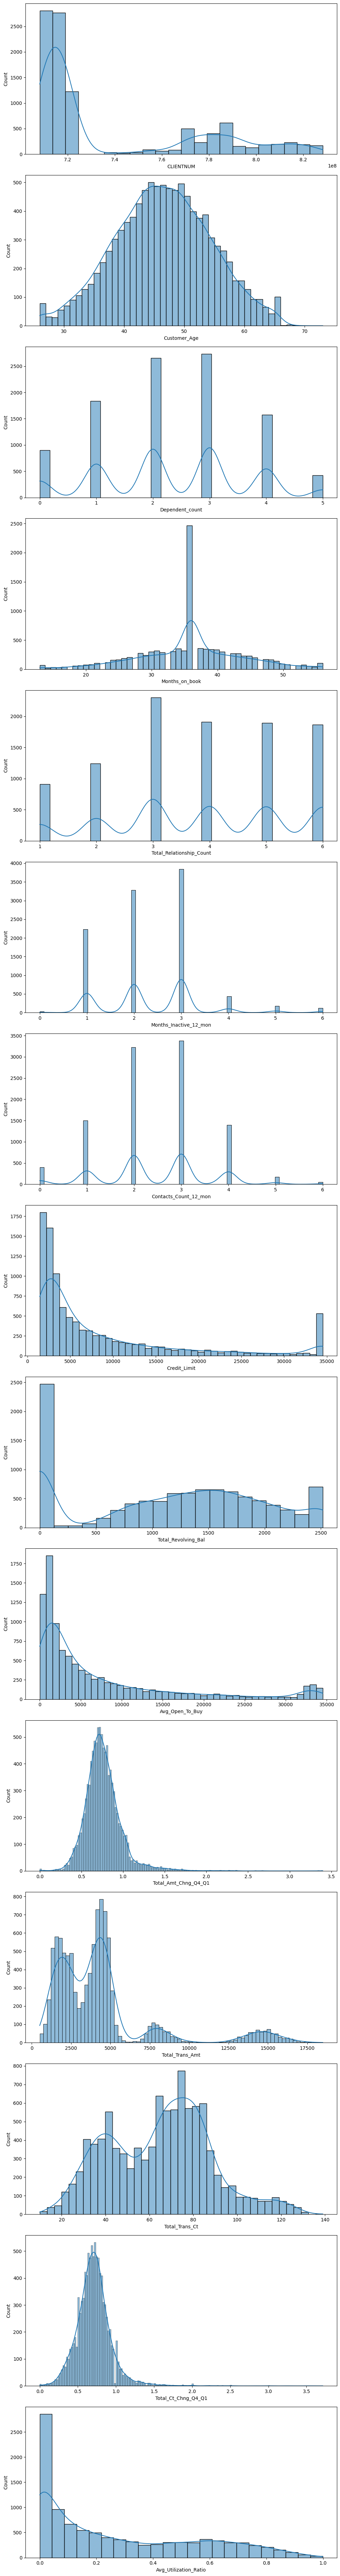

In [61]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Create histograms for numerical columns
fig, axs = plt.subplots(len(numerical_columns), figsize=(10, len(numerical_columns)*5))

for i, col in enumerate(numerical_columns):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])

plt.tight_layout()
plt.show()

The histograms provide insight into the distribution of each numerical variable in the dataset. Here are some observations:

> CLIENTNUM: This is the client's unique ID, so it does not have any particular distribution.

> Customer_Age: The distribution is nearly normal, with a slight skew to the right. Most customers are between 40 and 60 years old.

> Dependent_count: The distribution is nearly normal, with most customers having between 2 and 4 dependents.

> Months_on_book: The distribution is nearly normal, with most customers having been with the bank for around 30 to 40 months.

> Total_Relationship_Count: Most customers have around 3 to 5 products with the bank.

> Months_Inactive_12_mon: Most customers have been inactive for 1 to 3 months in the past 12 months.

> Contacts_Count_12_mon: Most customers have been contacted 2 to 3 times in the past 12 months.

> Credit_Limit: The distribution is right-skewed, with most customers having a credit limit less than $10,000.

> Total_Revolving_Bal: The distribution is multimodal (i.e., it has multiple peaks).

> Avg_Open_To_Buy: The distribution is right-skewed, similar to Credit_Limit.

> Total_Amt_Chng_Q4_Q1: The distribution is slightly right-skewed.

> Total_Trans_Amt: The distribution is right-skewed, with most total transaction amounts under $5000.

> Total_Trans_Ct: The distribution is slightly left-skewed, with most customers making around 60 to 80 transactions.

> Total_Ct_Chng_Q4_Q1: The distribution is slightly right-skewed.

> Avg_Utilization_Ratio: The distribution is left-skewed, with most customers having a low utilization ratio.

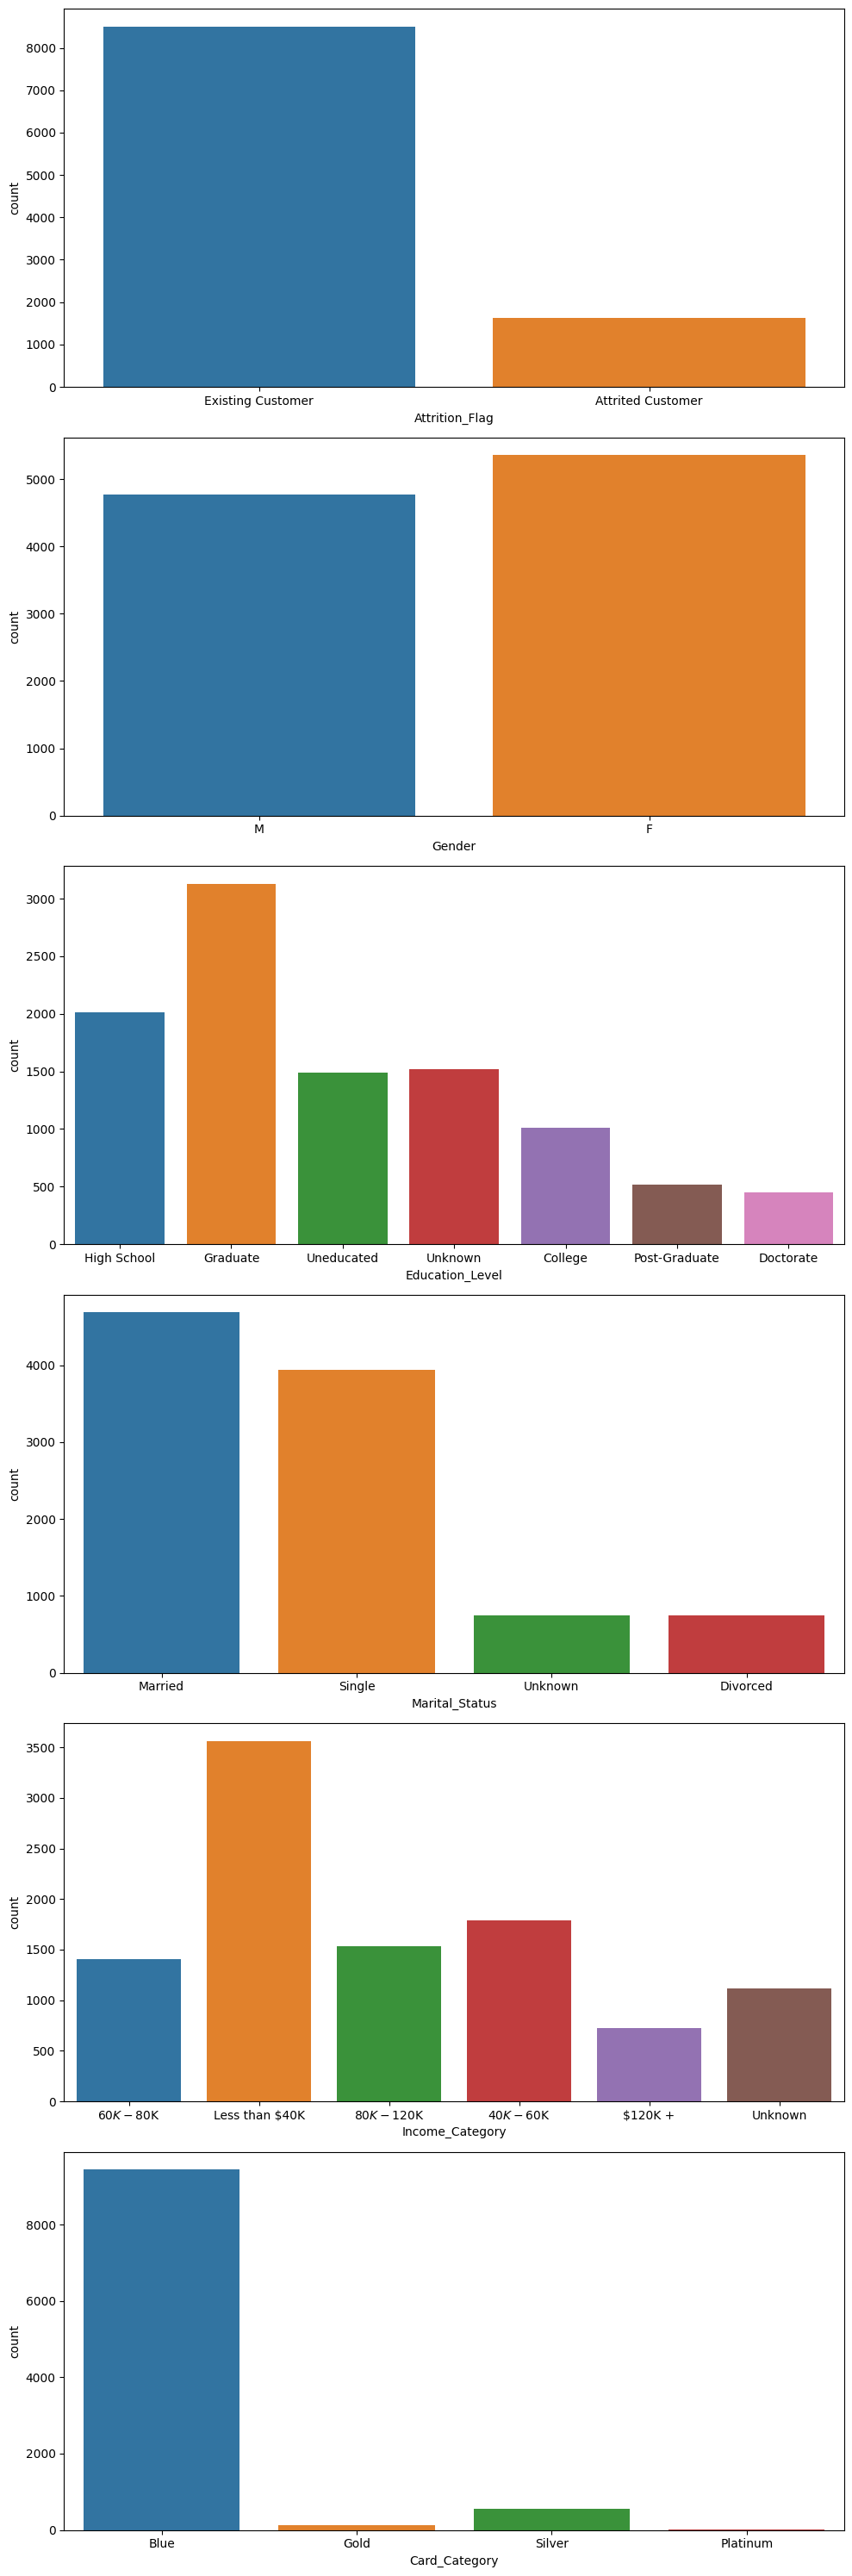

In [62]:
# Create bar plots for categorical columns
fig, axs = plt.subplots(len(categorical_columns), figsize=(10, len(categorical_columns)*5))

for i, col in enumerate(categorical_columns):
    sns.countplot(data=df, x=col, ax=axs[i])

plt.tight_layout()
plt.show()


The bar plots give us a visual representation of the frequency distribution of each categorical variable in the dataset. Here are some observations:

> Attrition_Flag: The majority of customers in the dataset are "Existing Customers". There are significantly fewer "Attrited Customers", indicating that the dataset is imbalanced.

> Gender: The distribution of genders is fairly balanced, with slightly more females than males.

> Education_Level: The most common education level is "Graduate", followed by "High School" and "Uneducated". There are also a significant number of "Unknown" entries.

> Marital_Status: The most common marital status is "Married", followed by "Single". There are also some "Unknown" entries.

> Income_Category: The most common income category is "Less than $40K", followed by "$40K - $60K" and "$80K - $120K". There are also some "Unknown" entries.

> Card_Category: Most customers have a "Blue" card. There are very few customers with "Gold" or "Platinum" cards.

# Correlation matrix for the numerical variables to understand the relationships between them

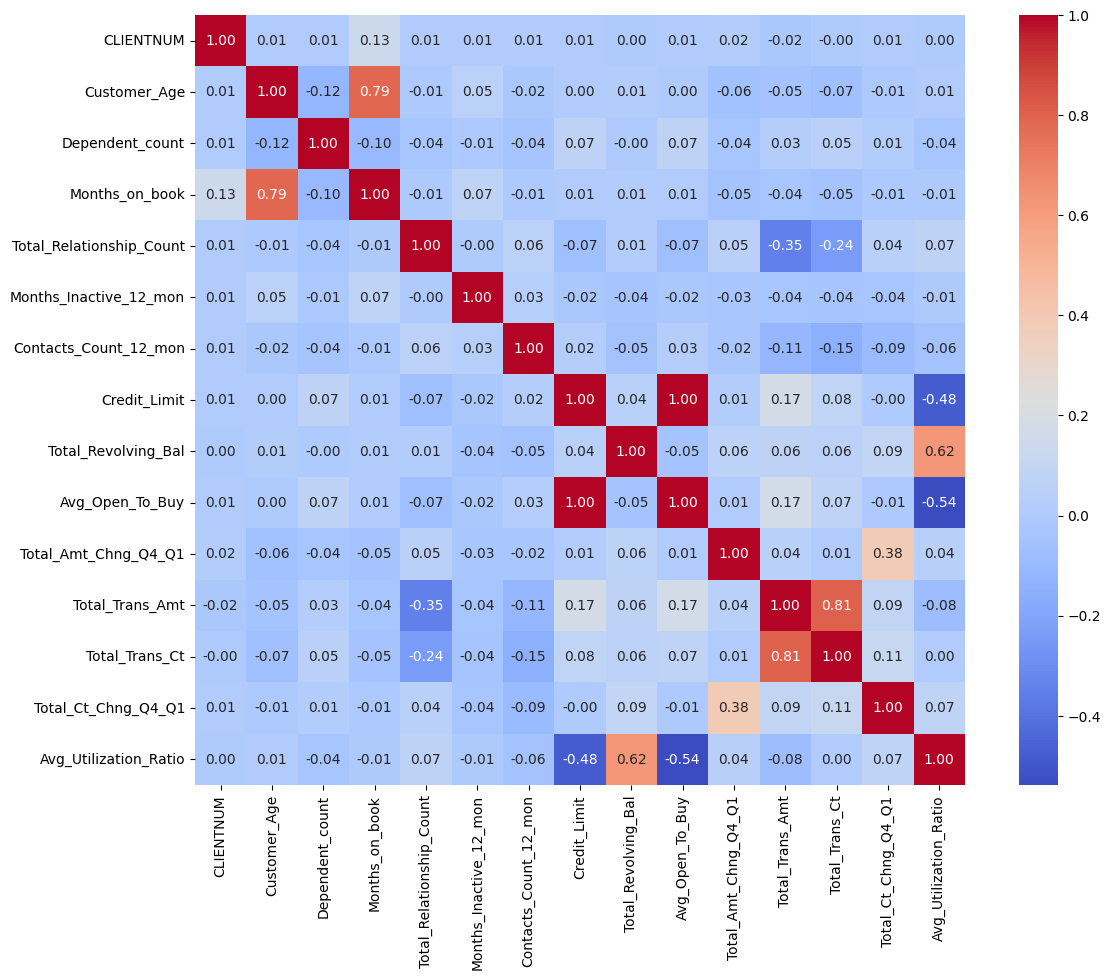

In [63]:
# Compute the correlation matrix
corr_matrix = df[numerical_columns].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.show()


Key Take Aways from the Corr Matrix :

> Customer_Age and Months_on_book have a high positive correlation (0.79), indicating that older customers tend to have older accounts.

> Total_Trans_Amt and Total_Trans_Ct also have a high positive correlation (0.81), which suggests that customers who make more transactions also tend to have higher transaction amounts.

> Credit_Limit and Avg_Open_To_Buy are perfectly positively correlated (1.00). This is expected, as "open to buy" refers to the amount remaining on a credit card to make purchases, which directly depends on the credit limit.

> Avg_Utilization_Ratio and Total_Revolving_Bal have a high positive correlation (0.62), suggesting that customers with higher revolving balances tend to have higher utilization ratios.

#Function for data cleaning

In [74]:
def clean_data(df):
    # Drop 'CLIENTNUM' column
    df = df.drop('CLIENTNUM', axis=1)

    # Apply label encoding to the target variable
    le = LabelEncoder()
    df['Attrition_Flag'] = le.fit_transform(df['Attrition_Flag'])

    # Apply one-hot encoding to the categorical variables
    df_encoded = pd.get_dummies(df)

    # Separate features and target variable
    X = df_encoded.drop('Attrition_Flag', axis=1)
    y = df_encoded['Attrition_Flag']

    # Store the columns
    columns = X.columns

    # Apply feature scaling to the numerical variables
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y, columns, scaler


In [65]:
def split_data(X, y):
    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


In [66]:
def build_and_eval_model(model, params, X_train, y_train, X_test, y_test):
    # Perform grid search to find the optimal hyperparameters
    clf = GridSearchCV(model, params, cv=5)

    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Print the classification report
    print(classification_report(y_test, y_pred))

    return clf

In [67]:
def predict(clf, X):
    # Use the trained model to make predictions
    return clf.predict(X)

In [79]:
# Use the functions
df = pd.read_csv('BankChurners.csv')
X, y, columns, scaler = clean_data(df)
X_train, X_test, y_train, y_test = split_data(X, y)

print("Random Forest:")
modelRF = RandomForestClassifier(random_state=42)
params = {'n_estimators': [50, 100, 200], 'class_weight':['balanced']}
clf_rf = build_and_eval_model(modelRF, params, X_train, y_train, X_test, y_test)

print("Predictions:", predict(clf_rf, X_test))

print("CatBoost:")
modelCAT = CatBoostClassifier(random_state=42, verbose=0)
params = {'iterations': [50, 100, 200], 'auto_class_weights':['Balanced']}
clf_cat = build_and_eval_model(modelCAT, params, X_train, y_train, X_test, y_test)

print("Predictions:", predict(clf_cat, X_test))

Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       327
           1       0.95      0.99      0.97      1699

    accuracy                           0.95      2026
   macro avg       0.94      0.85      0.89      2026
weighted avg       0.95      0.95      0.94      2026

Predictions: [1 1 1 ... 1 1 1]
CatBoost:
              precision    recall  f1-score   support

           0       0.86      0.94      0.89       327
           1       0.99      0.97      0.98      1699

    accuracy                           0.96      2026
   macro avg       0.92      0.95      0.94      2026
weighted avg       0.97      0.96      0.97      2026

Predictions: [1 1 1 ... 1 1 1]


In [69]:
def get_user_input():
    # This function should return a dataframe that contains the user's input in the same format as your training data
    input_data = {}
    input_data['Customer_Age'] = float(input("Enter customer age: "))
    input_data['Gender'] = input("Enter gender (M/F): ")
    input_data['Dependent_count'] = int(input("Enter dependent count: "))
    input_data['Education_Level'] = input("Enter education level: ")
    input_data['Marital_Status'] = input("Enter marital status: ")
    input_data['Income_Category'] = input("Enter income category: ")
    input_data['Card_Category'] = input("Enter card category: ")
    input_data['Months_on_book'] = int(input("Enter months on book: "))
    input_data['Total_Relationship_Count'] = int(input("Enter total relationship count: "))
    input_data['Months_Inactive_12_mon'] = int(input("Enter months inactive in last 12 months: "))
    input_data['Contacts_Count_12_mon'] = int(input("Enter contacts count in last 12 months: "))
    input_data['Credit_Limit'] = float(input("Enter credit limit: "))
    input_data['Total_Revolving_Bal'] = int(input("Enter total revolving balance: "))
    input_data['Avg_Open_To_Buy'] = float(input("Enter average open to buy: "))
    input_data['Total_Amt_Chng_Q4_Q1'] = float(input("Enter total amount change Q4 to Q1: "))
    input_data['Total_Trans_Amt'] = int(input("Enter total transaction amount: "))
    input_data['Total_Trans_Ct'] = int(input("Enter total transaction count: "))
    input_data['Total_Ct_Chng_Q4_Q1'] = float(input("Enter total count change Q4 to Q1: "))
    input_data['Avg_Utilization_Ratio'] = float(input("Enter average utilization ratio: "))

    return pd.DataFrame(input_data, index=[0])


In [77]:
def make_prediction(model, user_input, columns, scaler):
    # Ensure user input is in the right format
    user_input_df = pd.DataFrame(user_input, index=[0])

    # One-hot encode the user input
    user_input_encoded = pd.get_dummies(user_input_df)

    # Add missing columns with a value of zero
    missing_cols = set(columns) - set(user_input_encoded.columns)
    for col in missing_cols:
        user_input_encoded[col] = 0

    # Ensure the columns are in the same order as the training data
    user_input_encoded = user_input_encoded[columns]

    # Scale the user input
    user_input_scaled = scaler.transform(user_input_encoded)

    # Make the prediction
    prediction = model.predict(user_input_scaled)

    # Map the prediction to the original labels
    labels = {0: 'Attrited Customer', 1: 'Existing Customer'}
    prediction_label = labels[prediction[0]]

    # Return the prediction
    return prediction_label


# Hypothetical Customer Testing

" This hypothetical customer is a 40-year-old male with a graduate degree, who is married and has three dependents. He has been a customer for 36 months, has five total relationships, and has been inactive for 2 months in the past 12 months. His card is 'Blue', his income category is '$60K - $80K', and he has made contact with the bank three times in the past 12 months. He has a credit limit of 5000, a total revolving balance of 2000, and an average open-to-buy of $3000. He has had a total amount change of 0.8 from Q4 to Q1, a total transaction amount of 4000, a total transaction count of 70, a total count change of 0.75 from Q4 to Q1, and an average utilization ratio of 0.4. "

In [80]:
# Create a dummy user input
user_input = {
    'Customer_Age': 40,
    'Gender': 'M',
    'Dependent_count': 3,
    'Education_Level': 'Graduate',
    'Marital_Status': 'Married',
    'Income_Category': '$60K - $80K',
    'Card_Category': 'Blue',
    'Months_on_book': 36,
    'Total_Relationship_Count': 5,
    'Months_Inactive_12_mon': 2,
    'Contacts_Count_12_mon': 3,
    'Credit_Limit': 5000,
    'Total_Revolving_Bal': 2000,
    'Avg_Open_To_Buy': 3000,
    'Total_Amt_Chng_Q4_Q1': 0.8,
    'Total_Trans_Amt': 4000,
    'Total_Trans_Ct': 70,
    'Total_Ct_Chng_Q4_Q1': 0.75,
    'Avg_Utilization_Ratio': 0.4
}

# Use the function
prediction = make_prediction(clf_cat.best_estimator_, user_input, columns, scaler)
print("Prediction:", prediction)

Prediction: Existing Customer
